In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Perceptron,PassiveAggressiveClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier #Multi-Layer-Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc_curve

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import os
from functools import reduce

import seaborn as sns
%matplotlib inline


[Competencia de Titanic Kaggle](https://www.kaggle.com/competitions/titanic/data)

# Lectura de datos

Advanced feature engineering
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410

In [2]:
ruta_datos="C:\\Users\\MI10995\\Documents\\Capacitación\\Datos\\Pruebas_ML"
os.listdir(ruta_datos)
ruta_titanic=ruta_datos+'/titanic'
os.listdir(ruta_titanic)

['gender_submission.csv', 'MetaData.txt', 'test.csv', 'train.csv']

In [3]:
df = pd.read_csv(ruta_titanic+"/"+"train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [4]:
salida_ejemplo=pd.read_csv(ruta_titanic+"/"+"gender_submission.csv")
salida_ejemplo.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Ingeniería de Caracteristicas

## Constantes

In [5]:
vard=['Pclass','Sex','Embarked'] # Clase del ticket, Sexo, Embarcación de la que salio
varc_origin=['Age','SibSp','Parch','Fare'] # Años, hermanos supuestos a bordo, padres/hijos a bordo,Tarifa
um=['PassengerId']
tgt=['Survived']

## Ingeniería

In [6]:
def codificar_datos(X,varc_origin,vard):
    df_encoded=pd.get_dummies(X,columns=["Pclass","Sex","Embarked"])
    varc_enc=[v for v in df_encoded.columns if (v.find(vard[0])!=-1)|((v.find(vard[1])!=-1))|(v.find(vard[2])!=-1)]
    # Creación de nuevas variables
    varc=varc_origin+varc_enc
    
    return df_encoded[um+varc].copy()

In [7]:
X=codificar_datos(df[um+varc_origin+vard],varc_origin,vard)

In [8]:
# Definición de variables continuas
varc=[f for f in X.columns if f not in um]

In [9]:
tad=pd.merge(X,df[um+tgt],on=um,how="inner")
tad.shape

(891, 14)

# Análisis exploratorio

## Missings

In [10]:
miss=1-tad[varc].describe().T[['count']]/len(tad)
miss

,count
Age,0.198653
SibSp,0.000000
Parch,0.000000
Fare,0.000000
Pclass_1,0.000000
Pclass_2,0.000000
Pclass_3,0.000000
Sex_female,0.000000
Sex_male,0.000000
Embarked_C,0.000000


In [11]:
tad.shape,tad.dropna().shape

((891, 14), (714, 14))

In [12]:
tad=tad.dropna().reset_index(drop=True)
tad.tail()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
709,886,39.0,0,5,29.125,0,0,1,1,0,0,1,0,0
710,887,27.0,0,0,13.000,0,1,0,0,1,0,0,1,0
711,888,19.0,0,0,30.000,1,0,0,1,0,0,0,1,1
712,890,26.0,0,0,30.000,1,0,0,0,1,1,0,0,1
713,891,32.0,0,0,7.750,0,0,1,0,1,0,1,0,0


## Extremos

<AxesSubplot:>

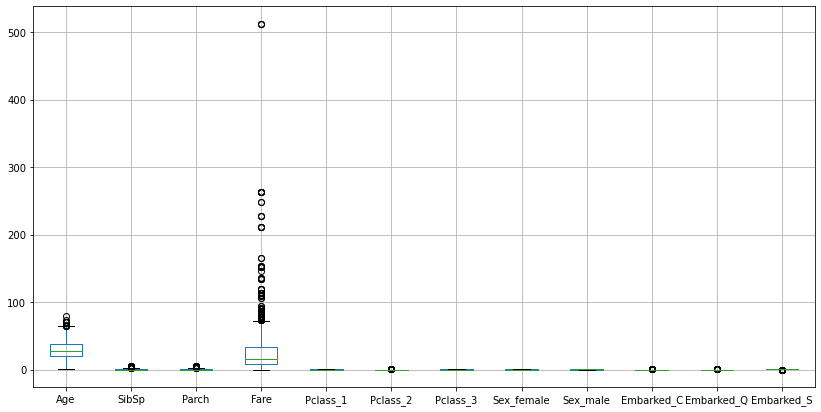

In [13]:
tad[varc].boxplot(figsize=(14,7))

In [14]:
ol = tad[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist()
for v,li,ls in ol:
    tad['ol_{}s'.format(v)] = ((tad[v]<li)|(tad[v]>ls)).astype(int)

In [15]:
varo = [v for v in tad.columns if v[:2]=='ol']
tad['ext'] = tad[varo].max(axis=1)
tad=tad.drop(varo,axis=1)

In [16]:
tad__not_ol=tad[tad["ext"]!=1]
tad.shape,tad__not_ol.shape

((714, 15), (673, 15))

Notamos que la distribución en el diagrama realmente no cambio mucho

<AxesSubplot:>

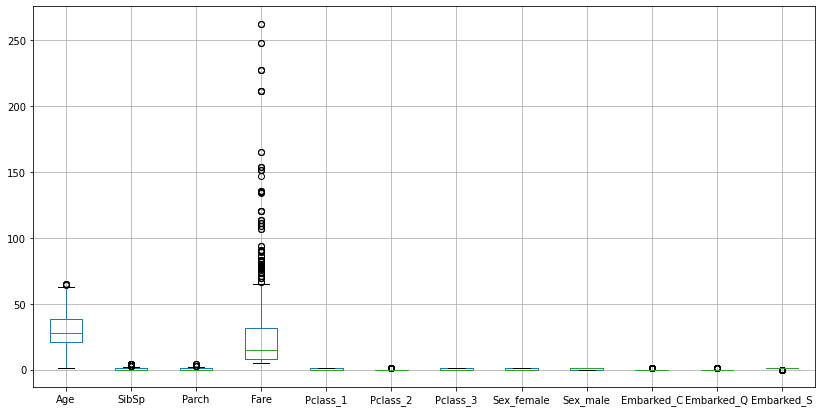

In [17]:
tad__not_ol[varc].boxplot(figsize=(14,7))

No hay diferencias significativas entre las distribuciones antes y después de los outliers

In [18]:
# Test de bondad de ajuste
from scipy.stats import ks_2samp
ks = pd.DataFrame(map(lambda v:(v,ks_2samp(tad__not_ol[v],tad[v]).statistic),varc),columns=['var','ks'])
rotas = sorted(ks.loc[ks['ks']>0.1]['var'])
rotas # El resultado vacío nos indica que no hay diferencia estadística entre tad y tad_e

[]

In [19]:
# Se toma la decisión de usar la tabla sin outliers
tad=tad__not_ol.drop("ext",axis=1)

## Unarias

In [20]:
# Eliminación de columnas unarias
mat=tad[varc].describe().T[['max',"min"]]
# No hay variables unarias
mat[mat["max"]==mat["min"]]

,max,min


No hay variables unarias al parecer

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Pclass_1'}>,
        <AxesSubplot:title={'center':'Pclass_2'}>,
        <AxesSubplot:title={'center':'Pclass_3'}>],
       [<AxesSubplot:title={'center':'Sex_female'}>,
        <AxesSubplot:title={'center':'Sex_male'}>,
        <AxesSubplot:title={'center':'Embarked_C'}>,
        <AxesSubplot:title={'center':'Embarked_Q'}>],
       [<AxesSubplot:title={'center':'Embarked_S'}>,
        <AxesSubplot:title={'center':'Survived'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

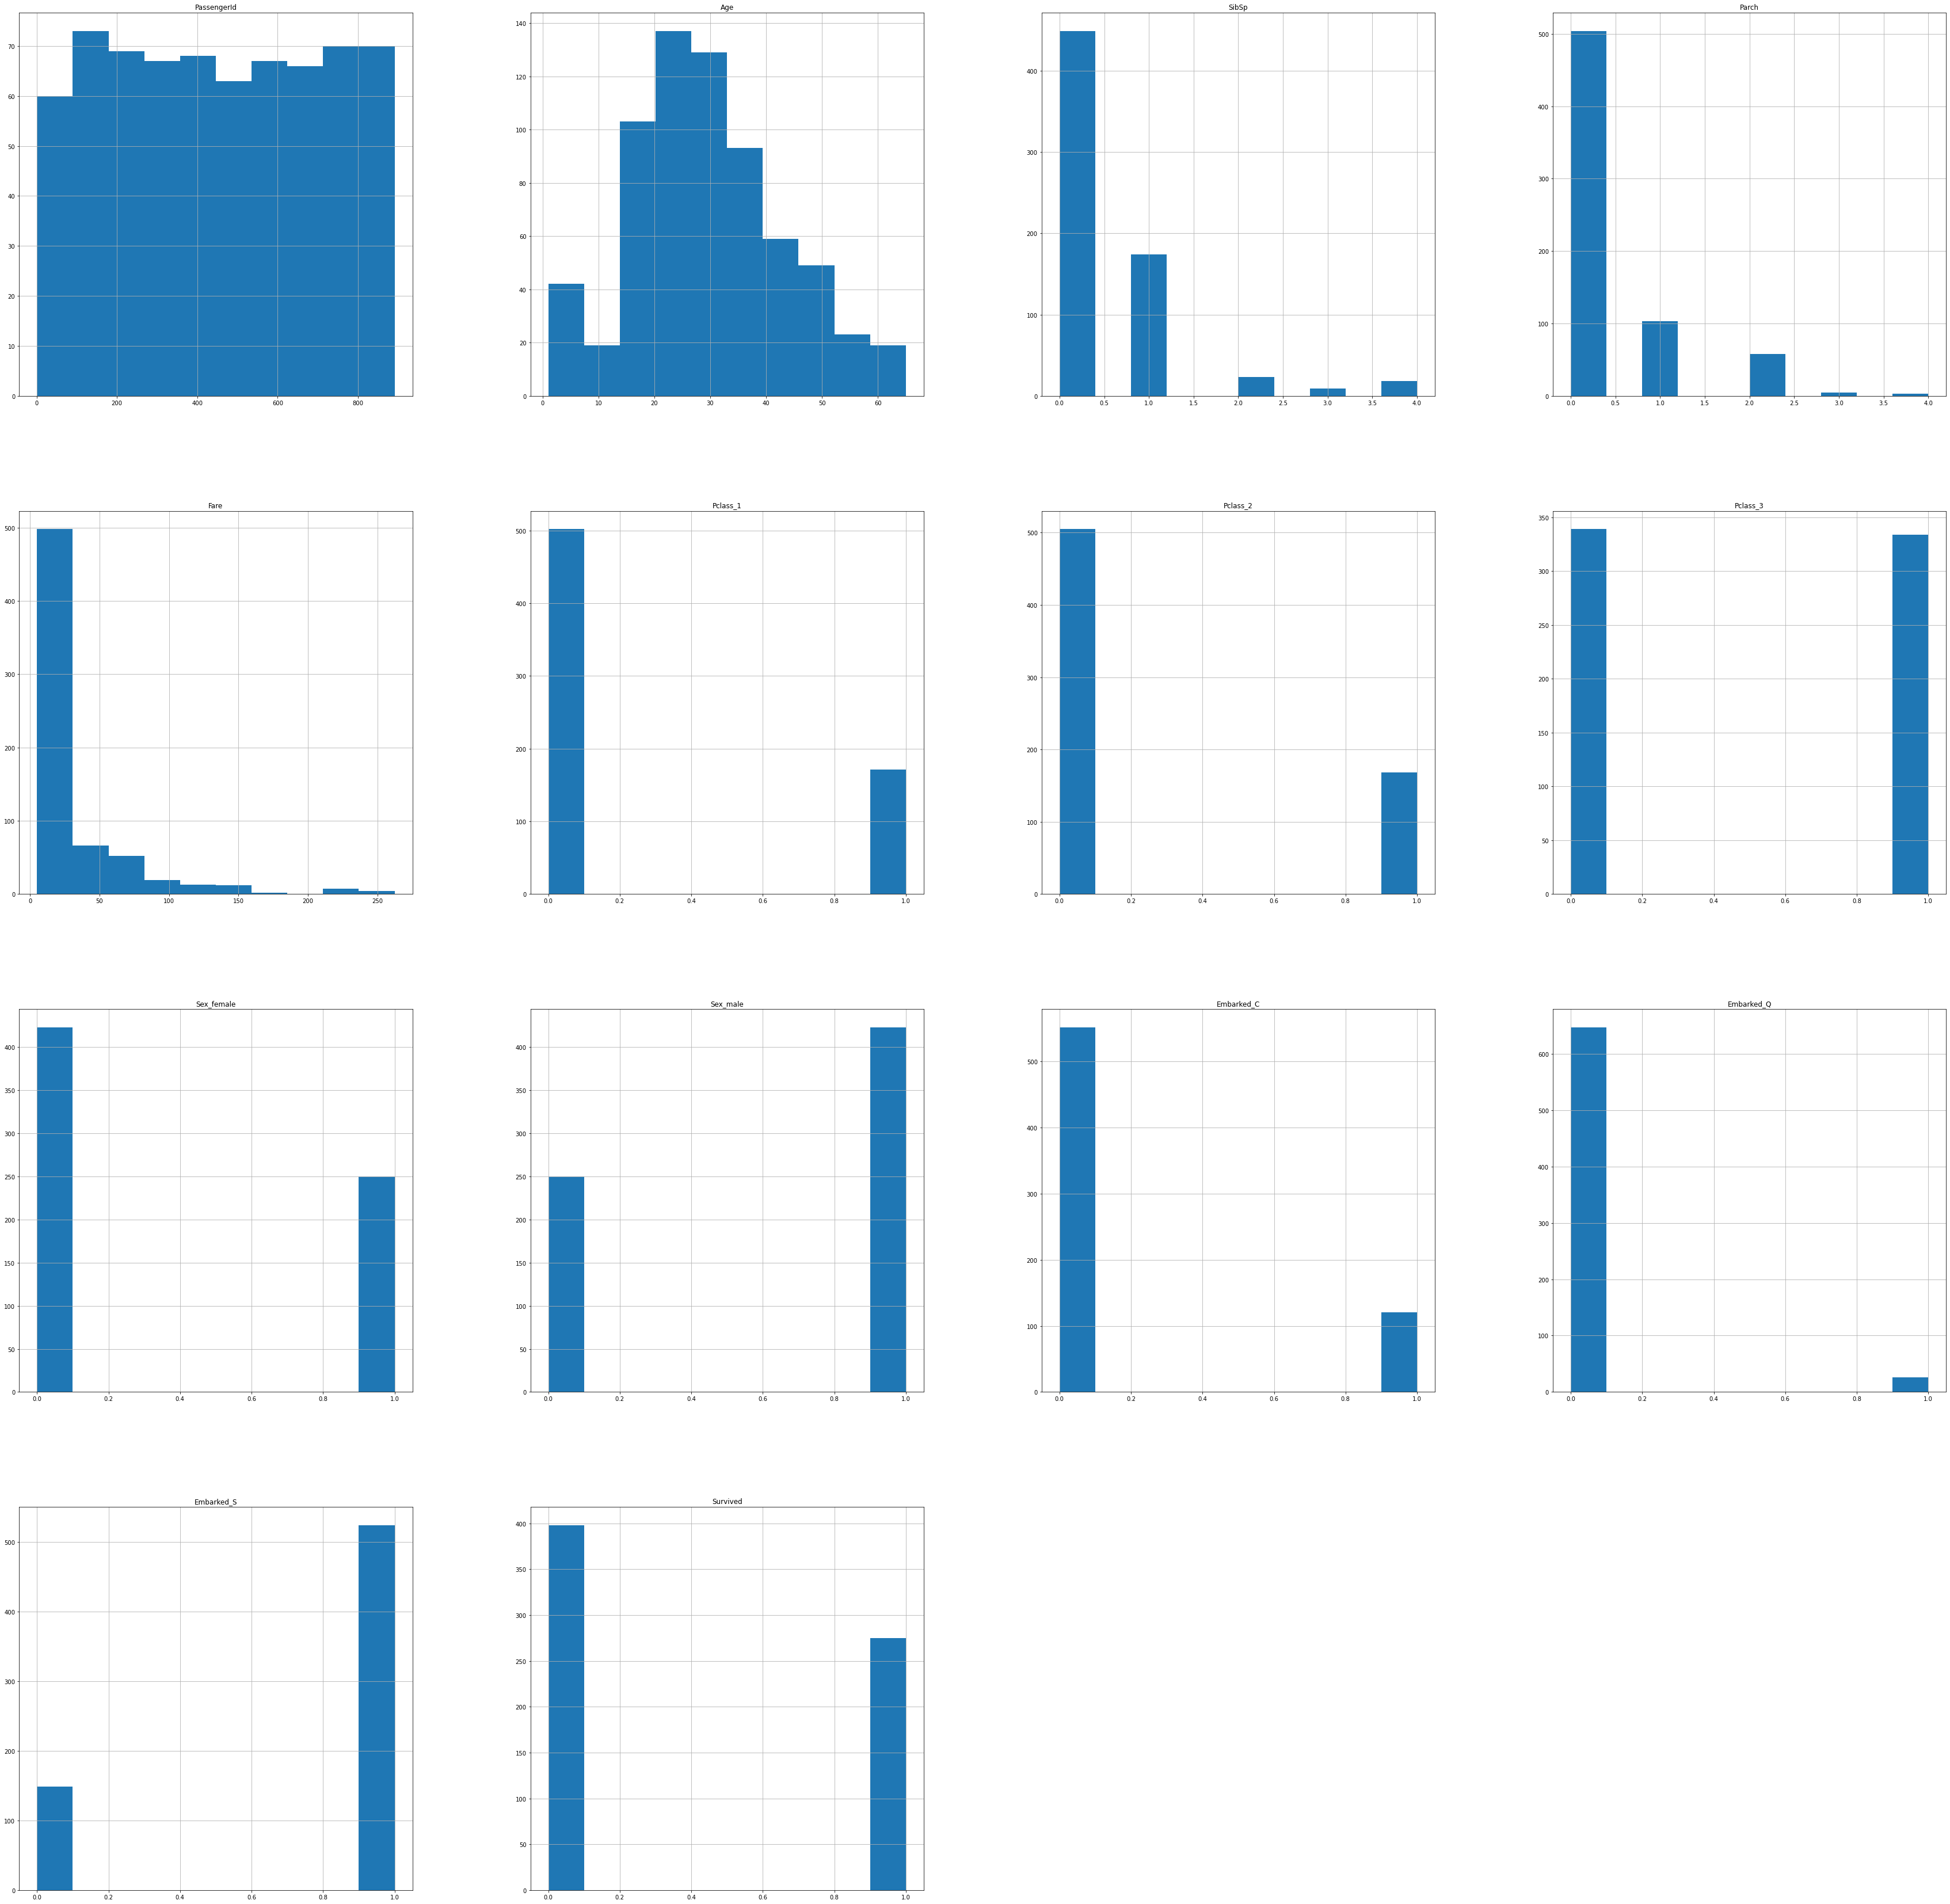

In [21]:
tad.hist(figsize=(60,60))

## Multicolinealidad

In [22]:
from varclushi import VarClusHi

In [23]:
tad[varc].head(2)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0


In [24]:
vc = VarClusHi(df=tad[varc],maxclus=10)

In [25]:
vc.varclus()
r2 = vc.rsquare

In [26]:
r2 = r2.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).reset_index(drop=True)

In [27]:
r2['importancia'] = r2.groupby('Cluster').cumcount()+1

Las mejores variables que tenemos en la tabla son las siguientes.

In [28]:
best = r2.loc[r2.importancia==1]['Variable'].tolist()
best

['Embarked_S', 'Sex_female', 'Pclass_1', 'SibSp', 'Embarked_Q']

## Correlación

In [29]:
mat=tad[varc].corr()
n=len(mat)
li=0.95
nom=[]
for i in range(1,n):
    if(mat.iloc[i].name in nom):
        continue
    for j in range(i+1,n):
        if(mat.iloc[i,j]>li or mat.iloc[i,j]<(-li)):
            nom.append(mat.iloc[:,j].name)

Sólo Una variable salio con una correlación muy alta

In [30]:
varc_no_correlacion=[ f for f in varc if f not in nom]

# Modelos

In [58]:
sc = StandardScaler()
X= pd.DataFrame(sc.fit_transform(tad[best]),columns=tad[best].columns)

In [59]:
X[best].describe()

,Embarked_S,Sex_female,Pclass_1,SibSp,Embarked_Q
count,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02
mean,-5.806813e-17,-4.718035e-17,2.396960e-16,3.193747e-16,-1.398914e-16
std,1.000744e+00,1.000744e+00,1.000744e+00,1.000744e+00,1.000744e+00
min,-1.875308e+00,-7.687760e-01,-5.836415e-01,-5.590524e-01,-2.004631e-01
25%,5.332459e-01,-7.687760e-01,-5.836415e-01,-5.590524e-01,-2.004631e-01
50%,5.332459e-01,-7.687760e-01,-5.836415e-01,-5.590524e-01,-2.004631e-01
75%,5.332459e-01,1.300769e+00,1.713380e+00,6.203904e-01,-2.004631e-01
max,5.332459e-01,1.300769e+00,1.713380e+00,4.158719e+00,4.988448e+00


In [60]:
y=tad[tgt]
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

## Perceptron

In [34]:
modelo = Perceptron()

In [35]:
#l2 es la norma cuadrada euclidiana y l1 es la norma absoluta, elasticnet es una combinación
#Se aplica el penalty a la función de perdida 0-1 del perceptron
hyper = dict(penalty = ['l2','l1','elasticnet'],
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000),
             eta0 = np.arange(0.1,1,0.1))

In [36]:
grid = GridSearchCV(estimator=modelo,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:   12.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, error_score='roc_auc', estimator=Perceptron(), n_jobs=-1,
             param_grid={'eta0': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(1000, 21000, 1000),
                         'penalty': ['l2', 'l1', 'elasticnet']},
             verbose=True)

In [37]:
print(grid.best_score_)

print(grid.best_params_)

0.7791932059447984
{'eta0': 0.9, 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2'}


In [38]:
modelo = grid.best_estimator_
modelo.fit(Xt,yt)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Perceptron(eta0=0.9, penalty='l2')

In [39]:
print(accuracy_score(y_true=yt,y_pred=modelo.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo.predict(Xv)))

0.6815286624203821
0.7079207920792079
[[231  53]
 [ 97  90]]
[[96 18]
 [41 47]]


## Pasivo-agresivo

In [ ]:
modelo2 = PassiveAggressiveClassifier()

In [ ]:
hyper = dict(C = np.arange(0.1,2,0.1),
             fit_intercept=[True,False],
             max_iter=range(1000,21000,1000))

In [ ]:
grid = GridSearchCV(estimator=modelo2,
                    error_score='roc_auc',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xt,yt)

In [ ]:
print(grid.best_score_)

print(grid.best_params_)

In [ ]:
modelo2 = grid.best_estimator_
modelo2.fit(Xt,yt)

In [ ]:
print(accuracy_score(y_true=yt,y_pred=modelo2.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modelo2.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modelo2.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modelo2.predict(Xv)))

## Maquina vector-soporte

In [ ]:
modelo3 = SVC()

In [ ]:
hyper = dict(C = np.arange(0.1,2,0.1),
             kernel=['linear', 'poly', 'rbf', 'sigmoid'],
             degree=range(2,6),
             gamma = ['scale', 'auto'],
             probability = [True]
            )

In [ ]:
sc = MinMaxScaler()
sc.fit(X)

In [ ]:
Xnt = pd.DataFrame(sc.transform(Xt),columns=best)
Xnv = pd.DataFrame(sc.transform(Xv),columns=best)

In [ ]:
grid = RandomizedSearchCV(estimator=modelo3,
                    error_score='roc_auc',
                    param_distributions=hyper,
                    n_iter=200,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

grid.fit(Xnt,yt)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
modelo3 = grid.best_estimator_

modelo3.fit(Xnt,yt)

In [ ]:
print(accuracy_score(y_true=yt,y_pred=modelo3.predict(Xnt)))
print(accuracy_score(y_true=yv,y_pred=modelo3.predict(Xnv)))

print(confusion_matrix(y_true=yt,y_pred=modelo3.predict(Xnt)))
print(confusion_matrix(y_true=yv,y_pred=modelo3.predict(Xnv)))

print(roc_auc_score(y_true=yt,y_score=modelo3.predict_proba(Xnt)[:,1]))
print(roc_auc_score(y_true=yv,y_score=modelo3.predict_proba(Xnv)[:,1]))

In [ ]:
plot_roc_curve(y_true=yt,y_probas=modelo3.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modelo3.predict_proba(Xv),curves='macro')

## Regresion logistica

In [61]:
from sklearn.pipeline import Pipeline

In [62]:
modeloRL = LogisticRegression()

In [63]:
sc = StandardScaler()
X= pd.DataFrame(sc.fit_transform(tad[best]),columns=tad[best].columns)

In [64]:
scaler=MinMaxScaler()
scaler.fit(X)
Xn = pd.DataFrame(scaler.transform(X),columns=best)
Xnt,Xnv,yt,yv = train_test_split(Xn,y,train_size=0.7)

In [65]:
hyper = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'] }

In [66]:
grid = GridSearchCV(estimator=modeloRL,
                    error_score='raise',
                    param_grid=hyper,
                    cv=3,
                    n_jobs=-1,
                    verbose=True)

In [70]:
grid.fit(Xnt,yt)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [78]:
print(grid.best_score_)
print(grid.best_params_)

0.8025477707006369
{'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}


In [102]:
modeloRL = grid.best_estimator_

modeloRL.fit(Xnt,yt)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=0.08858667904100823, penalty='l1', solver='liblinear')

In [103]:
print(roc_auc_score(y_score=modeloRL.predict_proba(Xnt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modeloRL.predict_proba(Xnv)[:,1],y_true=yv))

0.8461348340241075
0.7995955410871067


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

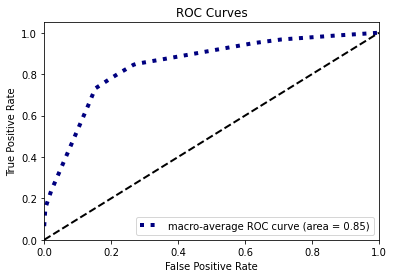

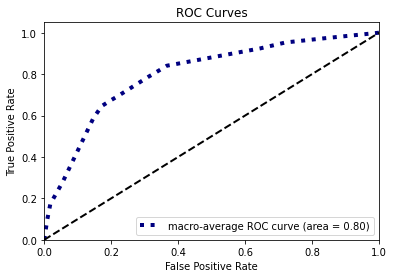

In [84]:
plot_roc_curve(y_true=yt,y_probas=modeloRL.predict_proba(Xnt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modeloRL.predict_proba(Xnv),curves='macro')

In [100]:
print(roc_auc_score(y_score=modelo_elegido.predict_proba(Xnt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modelo_elegido.predict_proba(Xnv)[:,1],y_true=yv))

0.5
0.5


## Random Forest

In [ ]:
modeloRL

In [ ]:
modeloRF=RandomForestClassifier()

In [ ]:
hyper = {'n_estimators' : list(range(10,101,10)),
    'max_features' : list(range(0,32)) }

In [ ]:
grid = GridSearchCV(estimator=modeloRF,
                    param_grid=hyper,
                    cv = 5, verbose=True, n_jobs=-1)

In [ ]:
grid.fit(Xt,yt)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
modeloRF=grid.best_estimator_
modeloRF.fit(Xt,yt)

In [ ]:
print(accuracy_score(y_true=yt,y_pred=modeloRF.predict(Xt)))
print(accuracy_score(y_true=yv,y_pred=modeloRF.predict(Xv)))

print(confusion_matrix(y_true=yt,y_pred=modeloRF.predict(Xt)))
print(confusion_matrix(y_true=yv,y_pred=modeloRF.predict(Xv)))

In [ ]:
print(roc_auc_score(y_score=modeloRF.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modeloRF.predict_proba(Xv)[:,1],y_true=yv))

In [ ]:
plot_roc_curve(y_true=yt,y_probas=modeloRF.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modeloRF.predict_proba(Xv),curves='macro')

## Red neuronal

In [ ]:
modeloRN = MLPClassifier()

In [ ]:
param = dict(hidden_layer_sizes = [(a,b,) for a in range(1,10)  for b in range(1,10)],
activation = ['identity', 'logistic', 'tanh', 'relu'],
solver = ['lbfgs', 'sgd', 'adam'],
alpha = np.arange(0.0001,0.001,0.0001),
learning_rate = ['constant', 'invscaling', 'adaptive'],
learning_rate_init = np.arange(0.001,0.01,0.001),
max_iter = [len(X)*2])

In [ ]:
grid = RandomizedSearchCV(estimator=modeloRN,
                          cv=10,
                          n_iter=300,
                          n_jobs=-1,
                          verbose=True,
                          scoring='roc_auc',
                          param_distributions=param)

In [ ]:
grid.fit(Xnt,yt)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
modeloRN = grid.best_estimator_

In [ ]:
modeloRN.fit(Xt,yt)

In [ ]:
print(roc_auc_score(y_score=modeloRN.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modeloRN.predict_proba(Xv)[:,1],y_true=yv))

In [ ]:
plot_roc_curve(y_true=yt,y_probas=modeloRN.predict_proba(Xt),curves='macro')
plot_roc_curve(y_true=yv,y_probas=modeloRN.predict_proba(Xv),curves='macro')

# Prueba con datos desconocidos

In [104]:
os.listdir(ruta_titanic)

['gender_submission.csv', 'MetaData.txt', 'test.csv', 'train.csv']

In [107]:
y_test=pd.read_csv(ruta_titanic+"/gender_submission.csv")
y_test.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [108]:
test=pd.read_csv(ruta_titanic+"/test.csv")
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [119]:
X=codificar_datos(test,varc_origin,vard)
# Aplicar escalamiento de modelo elegido, en este caso se eligio la regresión logistica que funciona mejor
scaler.fit(X[best])
X[best]=pd.DataFrame(scaler.transform(X[best]),columns=best)

In [120]:
tad_test=X.merge(y_test,on="PassengerId")
tad_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,892,34.5,0.000,0,7.8292,0.0,0,1,0.0,1,0,1.0,0.0,0
1,893,47.0,0.125,0,7.0000,0.0,0,1,1.0,0,0,0.0,1.0,1
2,894,62.0,0.000,0,9.6875,0.0,1,0,0.0,1,0,1.0,0.0,0
3,895,27.0,0.000,0,8.6625,0.0,0,1,0.0,1,0,0.0,1.0,0
4,896,22.0,0.125,1,12.2875,0.0,0,1,1.0,0,0,0.0,1.0,1


In [121]:
print(best)
print(accuracy_score(y_true=tad_test['Survived'],y_pred=modeloRL.predict(tad_test[best])))
print(roc_auc_score(y_score=modeloRL.predict_proba(tad_test[best])[:,1],y_true=tad_test['Survived']))

['Embarked_S', 'Sex_female', 'Pclass_1', 'SibSp', 'Embarked_Q']
1.0
1.0


In [124]:
tad_test["Revision"]=modeloRL.predict(tad_test[best])

In [125]:
salida=tad_test[["PassengerId"]].copy()
salida["Survived"]=modeloRL.predict(tad_test[best])
salida.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [126]:
salida[["Survived","PassengerId"]].to_csv("datos/salida.csv",index=False)